<a href="https://colab.research.google.com/github/KimNikita/machine-learning-practice/blob/main/Anime%20rating%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи

## Задача восстановления регрессии: предсказание ожидаемого конечного пользовательского рейтинга аниме по его характеристикам
## Область применения: упрощение выбора аниме для просмотра из числа вышедших в текущем сезоне года. Проблема состоит в том, что процент действительно "хороших" аниме среди вышедших довольно низок. При этом, чтобы отделить "хорошие" от "плохих", необходимо вручную просмотреть как минимум половину серий, что в худшем случае обернется потерей времени и настроения. А ориентироваться на пользовательский рейтинг первые полгода - бессмысленно ввиду разных причин (конкретика опускается).


# Чтение данных

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
url = "https://raw.githubusercontent.com/KimNikita/machine-learning-practice/main/anime-dataset-2023.csv"
data_raw = pd.read_csv(url)

In [ ]:
data_raw.shape

(24905, 24)

In [ ]:
data_raw.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,"Sep 1, 2001",...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


#Удаление ненужных столбцов

In [ ]:
data = data_raw.drop(data_raw.columns[[0, 1, 3, 6, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23]], axis=1)
data.head()

,English name,Score,Genres,Type,Episodes,Premiered,Source,Rating
0,Cowboy Bebop,8.75,"Action, Award Winning, Sci-Fi",TV,26.0,spring 1998,Original,R - 17+ (violence & profanity)
1,Cowboy Bebop: The Movie,8.38,"Action, Sci-Fi",Movie,1.0,UNKNOWN,Original,R - 17+ (violence & profanity)
2,Trigun,8.22,"Action, Adventure, Sci-Fi",TV,26.0,spring 1998,Manga,PG-13 - Teens 13 or older
3,Witch Hunter Robin,7.25,"Action, Drama, Mystery, Supernatural",TV,26.0,summer 2002,Original,PG-13 - Teens 13 or older
4,Beet the Vandel Buster,6.94,"Adventure, Fantasy, Supernatural",TV,52.0,fall 2004,Manga,PG - Children


#Удаление ненужных строк (фильтрация)

In [ ]:
data = data.loc[data['Score'] != 'UNKNOWN']
data = data.loc[data['Episodes'] != '1.0']
data = data.loc[data['Type'].isin(['ONA', 'TV', 'UNKNOWN'])]
data = data.loc[data['Source'].isin(['Original', 'Manga' 'Light novel', '4-koma manga', 'Visual novel', 'Other', 'Novel', 'Game', 'Book', 'Web manga', 'Mixed media', 'Card game', 'Web novel', 'UNKNOWN'])]

## Удаление "плохих" жанров

In [ ]:
cid = data.columns.get_loc('Genres')
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.find('Hentai') != -1 or cur.find('Erotica') != -1:
    rows_to_drop.append(i)

data.reset_index(inplace=True)
data.drop(rows_to_drop, inplace=True)
data.drop('index', inplace=True, axis=1)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)

## Удаление сиквелов \\ приквелов

In [ ]:
def mycmp(name):
  return len(name[0])

names=[]
i=0
for name in data['English name']:
  names.append((name, i))
  i+=1
names = sorted(names, key=mycmp)

rows_to_drop=[]
for index, name in enumerate(names):
  spaces = name[0].count(' ')
  for i in range(index+1, data.shape[0]):
    if names[i][0].count(' ') > spaces and names[i][0].startswith(name[0]):
      rows_to_drop.append(names[i][1])

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('English name', inplace=True, axis=1)

#Преобразование данных

## Столбец Score

In [ ]:
cid = data.columns.get_loc('Score')
for i in range(data.shape[0]):
  cur = round(float(data.iat[i, cid]), 1)
  data.iat[i, cid] = cur

## Столбец Genres

In [ ]:
unique_genres={}
cid = data.columns.get_loc('Genres')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  for genre in genres:
    if genre in unique_genres:
      unique_genres[genre]+=1
    else:
      unique_genres[genre]=0
unique_genres = sorted(unique_genres.items(), key=lambda item: item[1], reverse=True)
print(data.shape)
unique_genres

(2635, 7)


[('Comedy', 983),
 ('Action', 891),
 ('Fantasy', 733),
 ('Adventure', 608),
 ('Sci-Fi', 590),
 ('Drama', 417),
 ('Slice of Life', 326),
 ('Romance', 317),
 ('Supernatural', 200),
 ('Mystery', 188),
 ('UNKNOWN', 130),
 ('Ecchi', 97),
 ('Sports', 83),
 ('Horror', 69),
 ('Suspense', 46),
 ('Award Winning', 32),
 ('Gourmet', 32),
 ('Boys Love', 21),
 ('Girls Love', 15),
 ('Avant Garde', 11)]

In [ ]:
usable_genres=[]
for genre in unique_genres:
  if float(genre[1]) > data.shape[0]*0.05:
    usable_genres.append(genre[0])
    data.insert(cid+1, 'Genre ' + genre[0], 0)

usable_genres

['Comedy',
 'Action',
 'Fantasy',
 'Adventure',
 'Sci-Fi',
 'Drama',
 'Slice of Life',
 'Romance',
 'Supernatural',
 'Mystery']

In [ ]:
rows_to_drop=[]
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  genres = cur.split(', ')
  f=0
  for genre in genres:
    if genre not in usable_genres:
      f=1
      rows_to_drop.append(i)
      break
  if f==0:
    for genre in genres:
      data.iat[i, data.columns.get_loc('Genre ' + genre)]=1

data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.drop('Genres', inplace=True, axis=1)
data.shape

(2117, 16)

## Столбец Episodes

In [ ]:
cid = data.columns.get_loc('Episodes')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur != 'UNKNOWN':
    cur = float(cur)
    if cur <= 18:
      data.iat[i, cid] = 'half-season'
    elif 18 < cur <= 36:
      data.iat[i, cid] = 'season'
    elif 36 < cur <= 60:
      data.iat[i, cid] = 'double-season'
    elif 60 < cur:
      data.iat[i, cid] = 'no-season'

## Столбец Premiered

In [ ]:
cid = data.columns.get_loc('Premiered')
for i in range(data.shape[0]):
  cur = data.iat[i, cid]
  if cur.startswith('spring'):
    data.iat[i, cid] = 'spring'
  elif cur.startswith('summer'):
    data.iat[i, cid] = 'summer'
  elif cur.startswith('fall'):
    data.iat[i, cid] = 'fall'
  elif cur.startswith('winter'):
    data.iat[i, cid] = 'winter'


# Борьба с выбросами \\ пропущенными значениями (UNKNOWN)

In [ ]:
rows_to_drop = data[(data['Score'] < data['Score'].quantile(0.005)) | (data['Score'] > data['Score'].quantile(0.995))].index
data.drop(rows_to_drop, inplace=True)
data.reset_index(inplace=True)
data.drop('index', inplace=True, axis=1)
data.shape


(2096, 16)

In [ ]:
print(data['Type'].value_counts())
print(data['Episodes'].value_counts())
print(data['Premiered'].value_counts())
print(data['Source'].value_counts())
print(data['Rating'].value_counts())

TV     1511
ONA     584
Name: Type, dtype: int64
half-season      1196
season            444
double-season     357
no-season          74
UNKNOWN            24
Name: Episodes, dtype: int64
UNKNOWN    591
spring     492
fall       423
winter     332
summer     257
Name: Premiered, dtype: int64
Original        940
Game            267
Novel           234
Web manga       151
Other           147
4-koma manga    123
Visual novel     97
Mixed media      38
Web novel        34
Book             32
Card game        32
Name: Source, dtype: int64
PG-13 - Teens 13 or older         1310
G - All Ages                       425
PG - Children                      169
R - 17+ (violence & profanity)     140
R+ - Mild Nudity                    35
UNKNOWN                             16
Name: Rating, dtype: int64


In [ ]:
data=data.loc[data['Episodes'].isin(['half-season', 'season', 'double-season'])]
data=data.loc[data['Source'].isin(['Original', 'Game', 'Novel', 'Web manga', 'Other', '4-koma manga', 'Visual novel'])]
data=data.loc[data['Rating'].isin(['PG-13 - Teens 13 or older', 'G - All Ages', 'PG - Children', 'R - 17+ (violence & profanity)'])]
data.shape

(1827, 16)

In [ ]:
print(data['Premiered'].value_counts())

UNKNOWN    504
spring     442
fall       357
winter     293
summer     231
Name: Premiered, dtype: int64


# Преобразование типов

In [ ]:
data['Score'] = data['Score'].astype('float')
data['Type'] = data['Type'].astype('category')
data['Episodes'] = data['Episodes'].astype('category')
data['Premiered'] = data['Premiered'].astype('category')
data['Source'] = data['Source'].astype('category')
data['Rating'] = data['Rating'].astype('category')

# Визуализация

## В таблице чем правее находится жанр тем чаще он используется

In [ ]:
data.describe()

,Score,Genre Mystery,Genre Supernatural,Genre Romance,Genre Slice of Life,Genre Drama,Genre Sci-Fi,Genre Adventure,Genre Fantasy,Genre Action,Genre Comedy
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,6.535468,0.060208,0.069513,0.133005,0.149425,0.165298,0.251232,0.256158,0.297756,0.378763,0.407772
std,0.748171,0.237937,0.254394,0.339673,0.356605,0.371551,0.433840,0.436629,0.457397,0.485212,0.491555
min,4.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.100000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,8.400000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Большинство рассматриваемых аниме произведены в Японии, имеют длительность менее 18 серий, низкий возрастной рейтинг и не имеют текстового источника

In [ ]:
data.describe(include=['category'])

,Type,Episodes,Premiered,Source,Rating
count,1827,1827,1827,1827,1827
unique,2,3,5,7,4
top,TV,half-season,UNKNOWN,Original,PG-13 - Teens 13 or older
freq,1329,1104,504,887,1187


## Как видно из диаграммы, наличие таких жанров как Mystery, Supernatural, Romance, Drama, Adventure и Fantasy повышает шансы на более высокую оценку

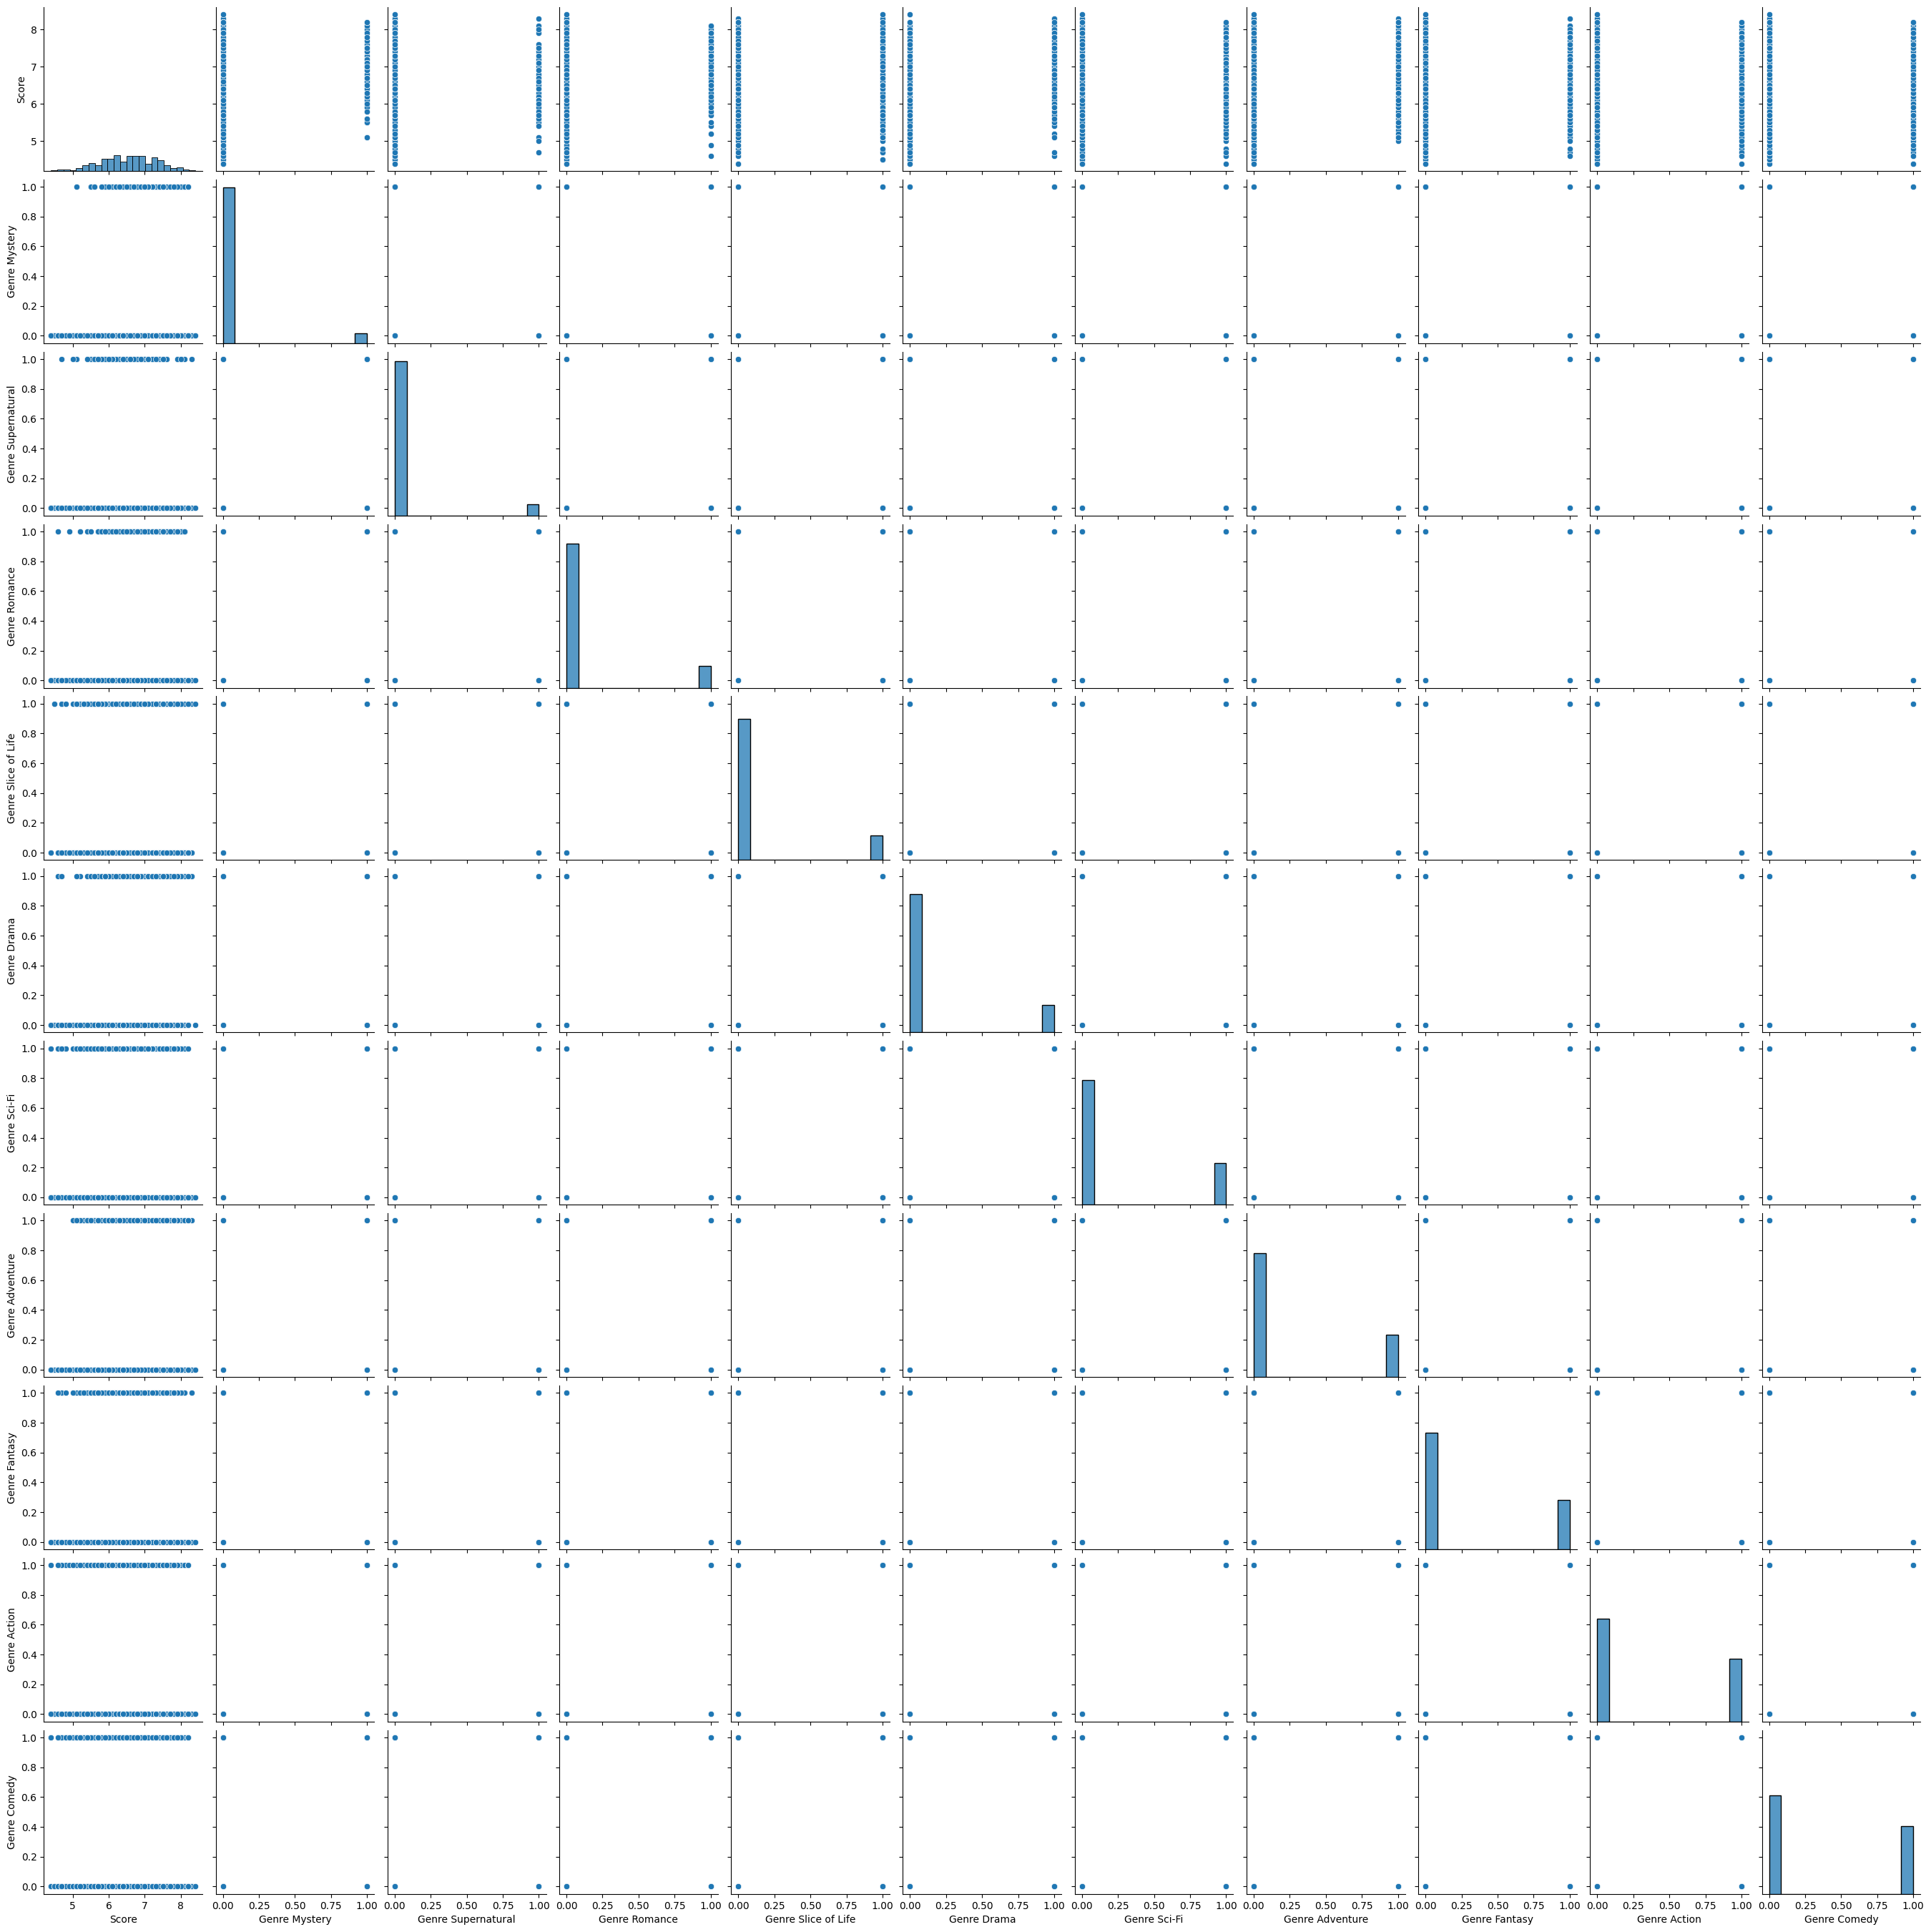

In [ ]:
sns.pairplot(data, diag_kind='hist')
pass

## Аниме, произведенное в Японии, в среднем имеет больший рейтинг

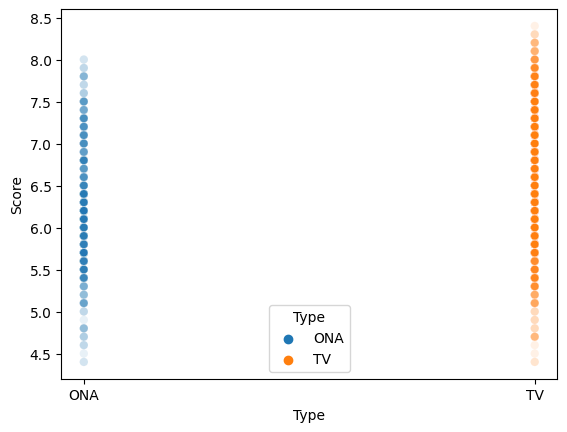

In [ ]:
sns.scatterplot(x='Type', y='Score', hue='Type', data=data, alpha=0.1)
pass

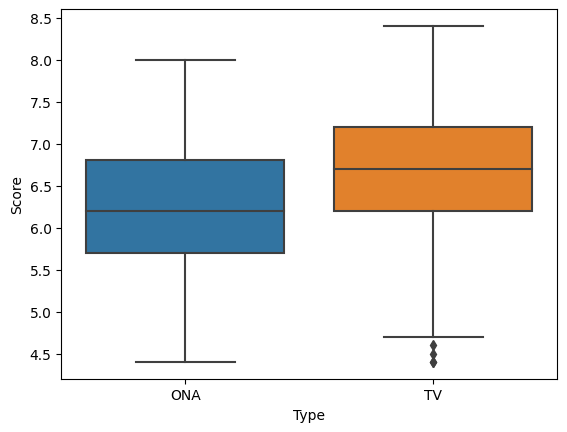

In [ ]:
sns.boxplot(x="Type", y="Score", data=data)
pass

## Аниме с большим количеством эпизодов в основном имеют высокие оценки, что можно объяснить более детальной экранизацией глав текстового источника

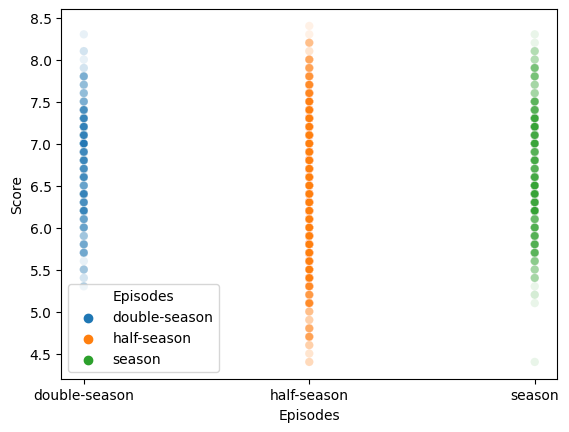

In [ ]:
sns.scatterplot(x='Episodes', y='Score', hue='Episodes', data=data, alpha=0.1)
pass

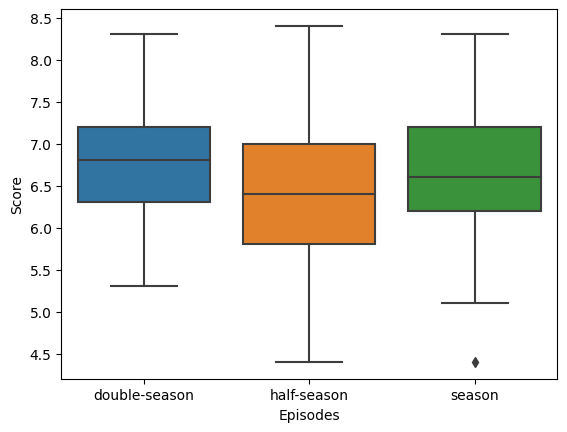

In [ ]:
sns.boxplot(x="Episodes", y="Score", data=data)
pass

## Аниме, выходящие зимой, немного выше оценены

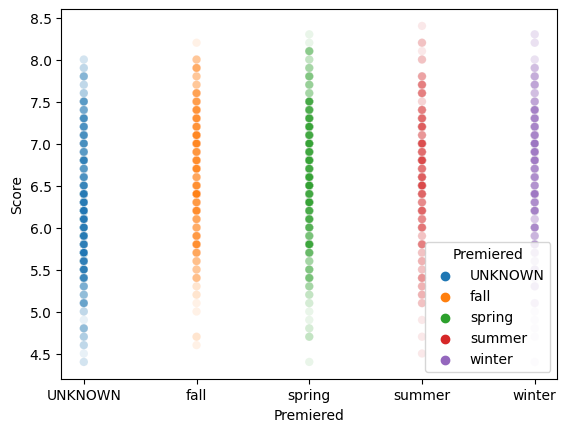

In [ ]:
sns.scatterplot(x='Premiered', y='Score', hue='Premiered', data=data, alpha=0.1)
pass

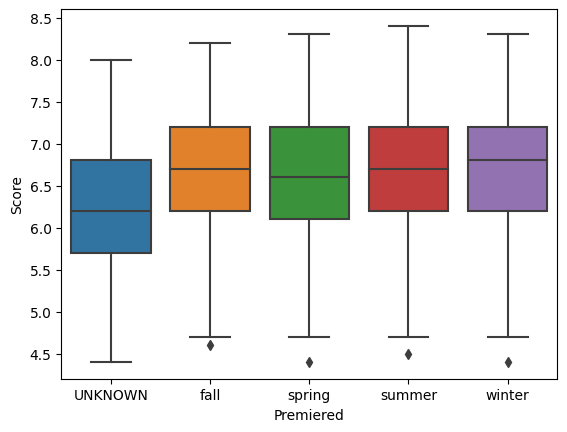

In [ ]:
sns.boxplot(x="Premiered", y="Score", data=data)
pass

## Как видно из диаграммы, аниме, имеющие такие текстовые источники, как 4-koma manga, Novel, Visual novel и Web manga, более высоко оценены

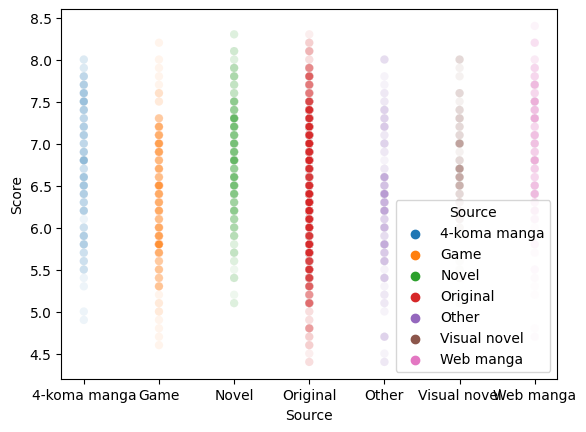

In [ ]:
sns.scatterplot(x='Source', y='Score', hue='Source', data=data, alpha=0.08)
pass

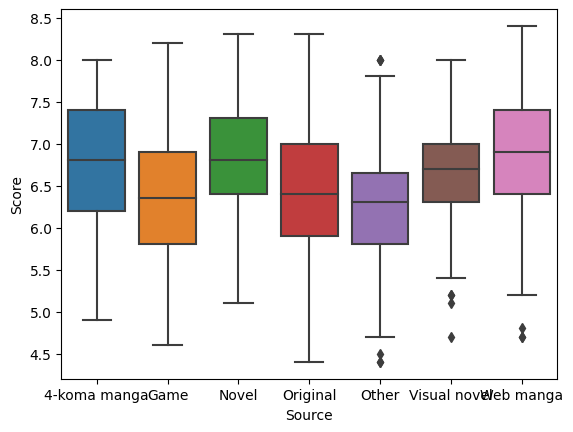

In [ ]:
sns.boxplot(x="Source", y="Score", data=data)
pass

## Корреляция

In [ ]:
corr_mat = data.corr()
corr_mat

<ipython-input-142-79907eedfcac>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


,Score,Genre Mystery,Genre Supernatural,Genre Romance,Genre Slice of Life,Genre Drama,Genre Sci-Fi,Genre Adventure,Genre Fantasy,Genre Action,Genre Comedy
Score,1.000000,0.075059,0.042572,0.158349,-0.020080,0.216684,0.046938,0.098576,0.041617,0.046096,-0.068683
Genre Mystery,0.075059,1.000000,0.147960,-0.004273,-0.093180,0.085593,0.017850,-0.011478,-0.069206,0.020568,-0.116380
Genre Supernatural,0.042572,0.147960,1.000000,0.026038,-0.042119,0.052187,-0.098777,-0.081509,-0.065020,-0.035950,-0.064759
Genre Romance,0.158349,-0.004273,0.026038,1.000000,-0.118954,0.242274,-0.074509,0.002783,0.030474,-0.093170,-0.046210
Genre Slice of Life,-0.020080,-0.093180,-0.042119,-0.118954,1.000000,-0.058388,-0.179067,-0.203756,-0.192344,-0.298788,0.058354
Genre Drama,0.216684,0.085593,0.052187,0.242274,-0.058388,1.000000,0.020820,-0.018093,-0.093201,-0.086230,-0.204342
Genre Sci-Fi,0.046938,0.017850,-0.098777,-0.074509,-0.179067,0.020820,1.000000,0.122649,-0.219873,0.276153,-0.211007
Genre Adventure,0.098576,-0.011478,-0.081509,0.002783,-0.203756,-0.018093,0.122649,1.000000,0.240351,0.195783,-0.122062
Genre Fantasy,0.041617,-0.069206,-0.065020,0.030474,-0.192344,-0.093201,-0.219873,0.240351,1.000000,0.160278,-0.131112
Genre Action,0.046096,0.020568,-0.035950,-0.093170,-0.298788,-0.086230,0.276153,0.195783,0.160278,1.000000,-0.326460


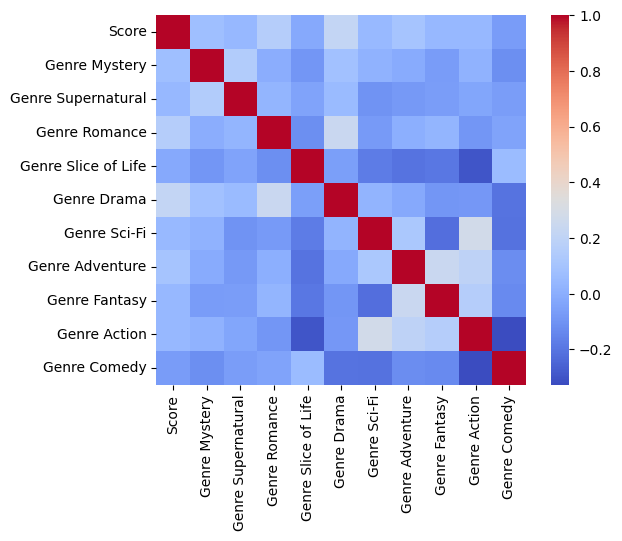

In [ ]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Так как признаки бинарные и до разбиения были частью составного признака, корреляция в основном показывает как часто 2 жанра встречаются вместе

In [ ]:
corr_mat.where(np.triu(corr_mat > 0.1, k=1)).stack().sort_values(ascending=False)

Genre Sci-Fi     Genre Action          0.276153
Genre Romance    Genre Drama           0.242274
Genre Adventure  Genre Fantasy         0.240351
Score            Genre Drama           0.216684
Genre Adventure  Genre Action          0.195783
Genre Fantasy    Genre Action          0.160278
Score            Genre Romance         0.158349
Genre Mystery    Genre Supernatural    0.147960
Genre Sci-Fi     Genre Adventure       0.122649
dtype: float64

# Нормализация

## Не учитываем столбец Premiered как особо не влияющий на Score

In [ ]:
data['Score'] = (data['Score'] - data['Score'].min()) / (data['Score'].max() - data['Score'].min())
data = pd.concat((data, pd.get_dummies(data['Type'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Episodes'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Source'])), axis=1)
data = pd.concat((data, pd.get_dummies(data['Rating'])), axis=1)

data.drop('Type', inplace=True, axis=1)
data.drop('Episodes', inplace=True, axis=1)
data.drop('Source', inplace=True, axis=1)
data.drop('Rating', inplace=True, axis=1)
data.drop('Premiered', inplace=True, axis=1)
data.shape

(1827, 27)

## Корреляция с учетом бинаризации номинальных признаков

In [ ]:
corr_mat = data.corr()
corr_mat.where(np.triu(corr_mat > 0.25, k=1)).stack().sort_values(ascending=False)

Genre Romance  Visual novel    0.360618
Genre Comedy   4-koma manga    0.284949
Genre Sci-Fi   Genre Action    0.276153
dtype: float64

# Machine learning

## Функция вычисления ошибки

In [ ]:
def my_score(X_test, y_test):
  # TODO сравнение на попадание в интервал 4.0-4.5, 4.5-5.0, 5.0-5.5, 5.5-6.0, 6.0-6.5, 6.5-7.0, 7.0-7.5, 7.5-8.0, 8.0-8.5
  # интервалов 9 -> ошибка = расстояние между интервалами/7
  pass

## Метод ближайших соседей

In [ ]:
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split

X = data.drop(['Score'], axis=1)
y = data['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(1370, 457)

In [ ]:
model = neighbors.KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.16854739130216023

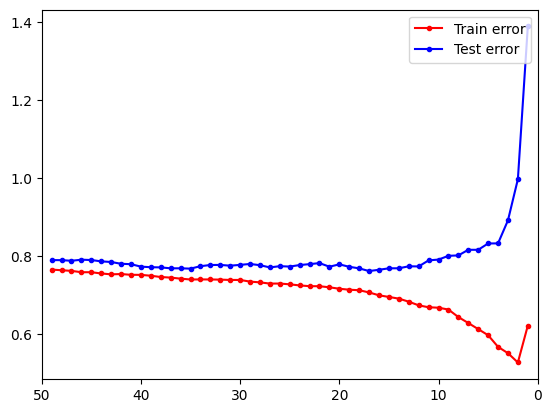

In [ ]:
from sklearn import neighbors, metrics
kk = range(1, 50)
err_train = []
err_test = []
for k in kk:
    model = neighbors.KNeighborsRegressor(n_neighbors = k)
    model.fit(X_train, y_train)
    err_train.append(1-model.score(X_train, y_train))
    err_test.append(1-model.score(X_test, y_test))
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')
plt.legend(loc = 1)
plt.xlim([50, 0])
pass

In [ ]:
model = neighbors.KNeighborsRegressor(n_neighbors = 17)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.2392453675284859

## Все плохо(

# TODO

## Придумать свой метод score \\ настроить существующий

## Запустить другие классификаторы. Сравнить результаты

## Cross validation

## Текстовый признак "сюжет" если все плохо

## Сделать общие выводы
